# Determining the value of a home

by Jarrid Jones 2022 July

### Project Goal

The goal of this project is to identify the drivers that determine the price of single family properties by constructing an ML Regression model. 

### Project Description

The cost of living and inflation is on the rise. The price of rent is also increasing and there is higher demand to purchase a home more than ever. Buyers want to find the home that works best for them. Location and home features can impact the value of the home. We will analayze data of homes that were purchased in the year 2017 from Zillow. The data will be helpful to  determine factors that impact the value of a home. 

### Initial Questions


- Does square footage (continuous variable) factor into the home value (continuous variable)?


- Does the lot size (continuous variable) help impact the home value (continuous variable)?


- Does having features like a garage size, pool, fire place, spa or hot tub (categorical variable) increase the home value (continuous variable)?


- Does fips (categorical variable) of a home impacts the home value (continuous variable)?



---

### Data Dictionary

|   Variable     |                  Meaning                   |
| -------------- | ------------------------------------------ |
| year           | The year the home was built                |
| home_value     | The total tax assessed value of the parcel |
| squarefeet     | The total square feet of a home            |
| lot_size       | The total square feet of a property lot    |
| fips           | Location of a home by county code          |
| bedrooms       | The total number of bedrooms in a home     |
| bathrooms      | The total number of bathrooms in a home    |
| hashottuborspa | Is there a hot tub or spa in home          |
| garagecarcount | The total number of car slots in a garage  |
| fireplace      | Is there a fireplace in home               |
| pool           | Is there a home pool                       |
| fips_encoded   | The location of a home by county, encoded  |
| home_age       | The age of the home since year built       |

 ---

In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.feature_selection import RFE
from acquire import get_db_url

### Wrangle Zillow Data


To acquire the zillow home data, I used the zillow_db in our mySQL server, and selected all columns from the customers, contract_types, internet_service, and payment_types table. 

"""

            select yearbuilt, taxvaluedollarcnt, calculatedfinishedsquarefeet, lotsizesquarefeet, fips, regionidzip, bedroomcnt, bathroomcnt,hashottuborspa, garagecarcnt, fireplacecnt,poolcnt
            from properties_2017 
            left join propertylandusetype  using (propertylandusetypeid)
            left join airconditioningtype  using (airconditioningtypeid)
            left join buildingclasstype  using (buildingclasstypeid)
            left join architecturalstyletype  using (architecturalstyletypeid)
            right join predictions_2017  using (parcelid)
            where propertylandusedesc = 'Single Family Residential'
            and predictions_2017.transactiondate like "2017%%";
                
                """

In [103]:
# acquire data from sql database 
import acquire
 
# make the connection the database and run the query and return the table in the form of a dataframe. 
df = acquire.new_familyhome17_data()

In [104]:
df.shape

(52441, 12)

In [105]:
df.head()

,yearbuilt,taxvaluedollarcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,fips,regionidzip,bedroomcnt,bathroomcnt,hashottuborspa,garagecarcnt,fireplacecnt,poolcnt
0,1998.0,1023282.0,3100.0,4506.0,6059.0,96978.0,4.0,3.5,NaN,2.0,NaN,NaN
1,1967.0,464000.0,1465.0,12647.0,6111.0,97099.0,2.0,1.0,NaN,1.0,1.0,NaN
2,1962.0,564778.0,1243.0,8432.0,6059.0,97078.0,3.0,2.0,NaN,2.0,NaN,1.0
3,1970.0,145143.0,2376.0,13038.0,6037.0,96330.0,4.0,3.0,NaN,NaN,NaN,1.0
4,1950.0,773303.0,2962.0,63000.0,6037.0,96293.0,4.0,3.0,NaN,NaN,NaN,1.0


**TAKEAWAYS**
- Raw dataset has 52441 rows and  12 columns
- Need to `poolcnt` fill null values with 0 
- Need to fill `garagecarcnt` null values with 0
- Need to fill `fireplacecnt` null values with 0
- Need to fill `hashottuborspa` null values with 0

### Prepare

**To prepare and clean the data, I did the following in order:**

Replaced null values with `0`: `poolcnt`, `garagecarcnt`, `fireplacecnt`, `hashottuborspa`

Encode Varaibles in column: `fips`

Data type change: `yearbuilt`,`fips` `regionidzip`, `bedroomcnt`, `hashottuborspa`, `garagecarcnt`, `fireplacecnt`, `poolcnt` to integer

Drop columns: `regionidzip`

Rename columns : {'yearbuilt':'year', 'taxvaluedollarcnt':'home_value', 'calculatedfinishedsquarefeet':'squarefeet', 'lotsizesquarefeet':'lot_size', 'bedroomcnt':'bedrooms', 'bathroomcnt':'bathrooms', 'fireplacecnt':'fireplace', 'poolcnt':'pool'}

Encoded column: `fips` as `fips_encoded` 6059: 2, 6037: 1, 6111: 3

Added new column:` home_age` = 2017 - df.year


In [106]:
import prepare
import pandas as pd
# Importing cleaned dataframe
df = prepare.prep_familyhome17()


**TAKEAWAYS**

- Refined dataset now is 51953 rows and 13 columns
- All missing values are filled or drop 

Now time to split the dataset into 3 sample sizes `train` , `validate`, `test`

### Split the Dataset

In [107]:
# spliting dataframe into 3 samples 
train, validate, test = prepare.split_familyhome17(df)

# Verifcation of split data set
print(train.shape)
print(validate.shape)
print(test.shape)

(29093, 13)
(12469, 13)
(10391, 13)


**TAKEAWAYS**

Our data is now split into 3 samples so that we can use the train sample to explore, fit to models and evaluate without looking at new data.

The validate is used to verify that our models built are not overfit to the train dataset.

The test set is used to give an estimate of how this model will perform on data is has never seen in the future.

---


### Exploratory Analysis: What determines the value of a home?


#### - Does square footage (continuous variable) factor into the home value (continuous variable)?

Null Hypothosis - Square footage does not impact the home value.

Alternate -  Square footage does impact the home value.

In [108]:
import scipy.stats as stats

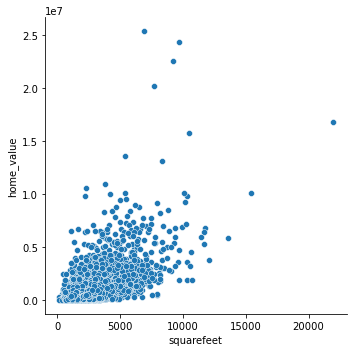

In [109]:
sns.relplot(x="squarefeet", y="home_value", data=train)
plt.show()

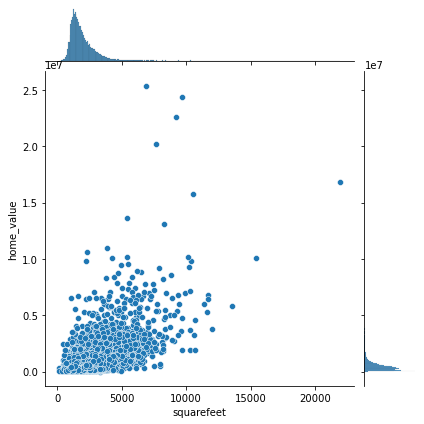

In [110]:
sns.jointplot(x="squarefeet", y="home_value", data=train)


In [111]:
alpha = .05

x= train.squarefeet
y = train.home_value

r, p = stats.pearsonr(x, y)
print('r =', r)
print('p =', p)

if p < alpha:
    print("We reject the hypothesis")
else:
    print("We fail to reject the null hypothesis")

r = 0.6072500030108557
p = 0.0
We reject the hypothesis


Squarefeet is a factor of home value.

#### - Does the lot size (continuous variable) help impact the home value (continuous variable)?

Null Hypothosis -  lot size does impact the home value.

Alternate -  lot sizee does not impact the home value.


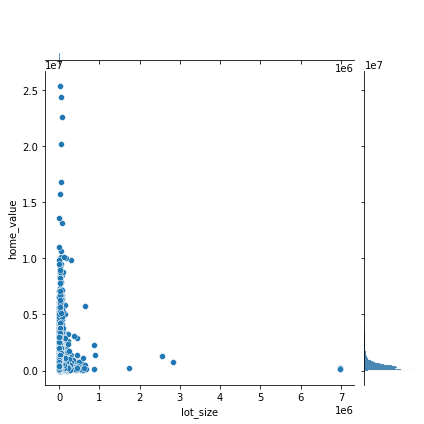

In [112]:
sns.jointplot(x="lot_size", y="home_value", data=train)


In [113]:
x= train.lot_size
y = train.home_value

r, p = stats.pearsonr(x, y)
print('r =', r)
print('p =', p)

if p < alpha:
    print("We reject the hypothesis")
else:
    print("We fail to reject the null hypothesis")

r = 0.028472688329206127
p = 1.1901611724770776e-06
We reject the hypothesis


#### - Does having features like a garage size, pool, fire place, spa or hot tub (categorical variable) increase the home value (continuous variable)?

Null Hypothosis -  feature not does impact the home value.

Alternate -  features does  impact the home value.

<AxesSubplot:xlabel='garagecarcnt', ylabel='home_value'>

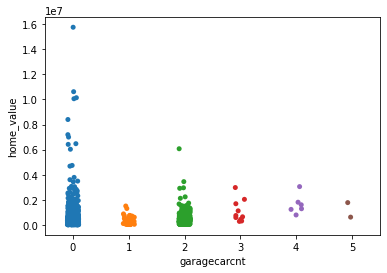

In [114]:
# create a sample of train 
sample = train.sample(frac=0.05)

sns.stripplot(x='garagecarcnt', y='home_value', data=sample)

<AxesSubplot:xlabel='garagecarcnt', ylabel='home_value'>

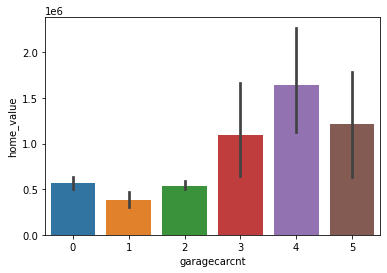

In [115]:
sns.barplot(x='garagecarcnt', y='home_value', data=sample)

In [127]:
garagesz = train.garagecarcnt
hv = train.home_value.mean()

t, p = stats.ttest_1samp(garagesz, hv)

print(t, p/2, alpha)

if p/2 > alpha:
    print("We fail to reject null hypothesis")

else:
    print("We reject null hypothesis")

-91828961.53827903 0.0 0.05
We reject null hypothesis


#### - Does fips (categorical variable) of a home impacts the home value (continuous variable)?

Null Hypothosis -  fips not does impact the home value.

Alternate -  fips does  impact the home value.

/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 86.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 77.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 53.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='fips', ylabel='home_value'>

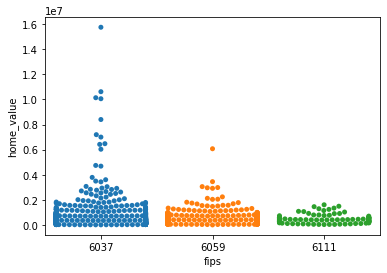

In [116]:
# plot sample size of train 
sns.swarmplot(x='fips', y='home_value', data=sample)

<AxesSubplot:xlabel='fips', ylabel='home_value'>

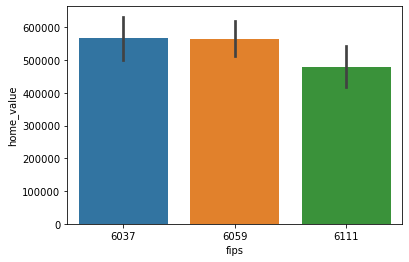

In [117]:
# Plot of the distribution of fips vs home value
sns.barplot(x='fips', y='home_value', data=sample)

In [128]:
fips = train.fips
hv = train.home_value.mean()

t, p = stats.ttest_1samp(fips, hv)

print(t, p/2, alpha)

if p/2 > alpha:
    print("We fail to reject null hypothesis")

else:
    print("We reject null hypothesis")



-4227883.4573870795 0.0 0.05
We reject null hypothesis


Correlation and Heat Map of the correlation of each feature in the sample data

In [ ]:
# Create the correlation matrix for all exams.

zill_corr = train.corr()
zill_corr


,year,home_value,squarefeet,lot_size,fips,bedrooms,bathrooms,hashottuborspa,garagecarcnt,fireplace,pool,fips_encoded,home_age
year,1.000000,0.183667,0.457174,0.038428,0.301506,0.384845,0.523917,0.192050,0.410467,0.205695,0.123787,0.349744,-1.000000
home_value,0.183667,1.000000,0.607250,0.028473,0.025718,0.272367,0.523535,0.143099,0.103425,0.058170,0.225609,0.040806,-0.183667
squarefeet,0.457174,0.607250,1.000000,0.051079,0.113900,0.629162,0.849803,0.240047,0.242823,0.171450,0.365466,0.136208,-0.457174
lot_size,0.038428,0.028473,0.051079,1.000000,-0.006798,0.014511,0.037209,-0.000511,-0.012034,0.007770,0.024526,-0.013634,-0.038428
fips,0.301506,0.025718,0.113900,-0.006798,1.000000,0.140461,0.114951,0.082733,0.736790,0.630079,0.012378,0.963290,-0.301506
bedrooms,0.384845,0.272367,0.629162,0.014511,0.140461,1.000000,0.642822,0.134775,0.212387,0.145440,0.260456,0.157412,-0.384845
bathrooms,0.523917,0.523535,0.849803,0.037209,0.114951,0.642822,1.000000,0.202308,0.232042,0.142343,0.327822,0.139700,-0.523917
hashottuborspa,0.192050,0.143099,0.240047,-0.000511,0.082733,0.134775,0.202308,1.000000,0.282066,0.042103,0.205153,0.153258,-0.192050
garagecarcnt,0.410467,0.103425,0.242823,-0.012034,0.736790,0.212387,0.232042,0.282066,1.000000,0.511846,0.071753,0.862480,-0.410467
fireplace,0.205695,0.058170,0.171450,0.007770,0.630079,0.145440,0.142343,0.042103,0.511846,1.000000,0.098871,0.607741,-0.205695


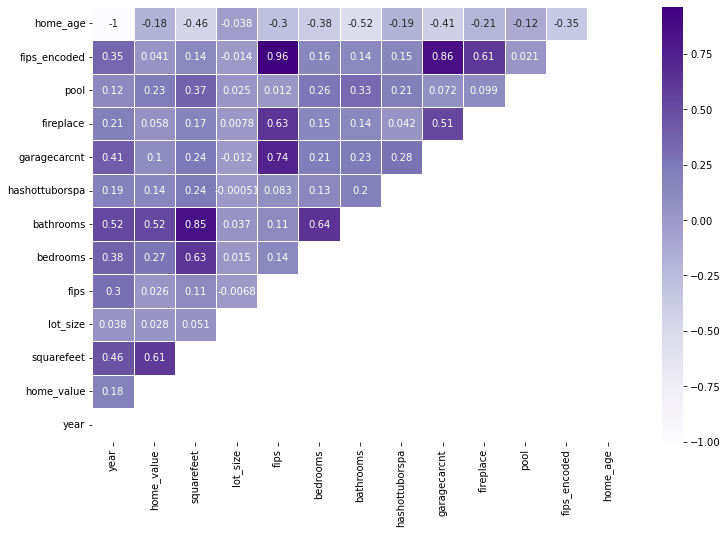

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(zill_corr, cmap='Purples', annot=True, linewidth=0.5, mask= np.triu(zill_corr))
plt.ylim(0, 13)

plt.show()


#### Summary: What factors in to the home value?

**TAKEAWAYS**
Squarefeet, features like garage size and pool, fips location all do factor into the value of a home

---

### Scaling the data to normalize it

In [ ]:
# Function to scale data using the Robust Scaler. Object scales columns 'squarefeet', 'lot_size', 'bedrooms', 'bathrooms','garagecarcnt', 'fips_encoded', 'home_age' train sample and transforms validate and test samples.
train_s, valid_s, test_s = prepare.scale_data(train, validate, test)

# Print shape of scaled samples
train_s.shape, valid_s.shape, test_s.shape

((29093, 13), (12469, 13), (10391, 13))

In [ ]:
#Preview of scaled data
train_s.head()

,year,home_value,squarefeet,lot_size,fips,bedrooms,bathrooms,hashottuborspa,garagecarcnt,fireplace,pool,fips_encoded,home_age
50541,1989,686554.0,0.359691,-1.648573,6059,-1.0,0.5,0,1.0,0,0,1.0,-1.000000
22959,1909,112711.0,-0.570878,-0.512407,6037,-1.0,-1.0,0,0.0,0,0,0.0,1.758621
32939,1977,227008.0,-0.055931,-0.637407,6037,1.0,1.0,0,0.0,0,0,0.0,-0.586207
26019,1948,2100339.0,1.191900,1.218362,6037,0.0,0.0,0,0.0,0,1,0.0,0.413793
35209,1975,347952.0,0.792671,-0.032878,6059,0.0,0.5,0,1.0,0,1,1.0,-0.517241


**TAKEAWYS**

- Scaled samples using Robust Scaler to deal with outliers
- Everything normalized except columns `home_value`, `year`, `fips`. Will omit columns when running models


---

### Predicting home value

In [ ]:
 # drop target variable and encoded variable from train sample 
X_train = train_s.drop(columns=['home_value', 'fips', 'year'])
    
# dataframe with the target variable only
y_train = train.home_value

#### Baseline

I will set a baseline prediction by predicting home homevalues are the mean of home value in train sample. I will evaluate the accuracy of that.



The mean of home value is a great baseline

In [ ]:
# Create dataframe with actual and baseline home value on train

home_value_mean =  pd.DataFrame(train.home_value)

home_value_mean["baseline"]= train.home_value.mean()

# Create dataframe with actual and baseline home value on validate

validate_home_value_mean =  pd.DataFrame(validate.home_value)

validate_home_value_mean["baseline"]= train.home_value.mean()

#### Fit 3 models

The top 3 models we built were LinearRegression (OLS), LassoLars, and TweedieRegressor (GLM). The models differed in the features and the algorithms.

#####  Simple Model of Regression

In [ ]:
from sklearn.linear_model import LinearRegression



# 1. make the thing
lm = LinearRegression()
# 2. fit the thing
lm.fit(X_train, y_train)
# 3. use the thing (make predictions)
lm_predict = train_s.drop(columns=['home_value', 'fips', 'year'])
home_value_mean['simple_lm'] = lm.predict(lm_predict)

valid_s_lm_predict = valid_s.drop(columns=['home_value', 'fips', 'year'])
validate_home_value_mean['simple_lm'] = lm.predict(valid_s_lm_predict)

In [ ]:
lm.coef_, lm.intercept_

(array([ 4.88056710e+05, -6.80557633e+01, -1.45799118e+05,  1.12617924e+05,
         1.36234888e+04, -2.42874586e+04, -6.20962221e+04,  6.75866714e+03,
         4.61598413e+04,  1.12541145e+05]),
 422427.44812306843)

In [ ]:
print('home value = {:.3f} * features + {:.3f}'.format(lm.coef_[0], lm.intercept_))

home value = 488056.710 * features + 422427.448


##### LassoLars

In [ ]:
from sklearn.linear_model import LassoLars

# create the model object
lars = LassoLars(alpha=5)

# fit the model to our training data= 
lars.fit(X_train, y_train)

# predict train
X_train_pred_lars = lars.predict(train_s.drop(columns=['home_value', 'fips', 'year']))

# Add lassolars predictions to our predictions DataFrame
home_value_mean['lasso_lars'] = X_train_pred_lars

# predict validate
X_validate_pred_lars = lars.predict(valid_s.drop(columns=['home_value', 'fips', 'year']))

# Add lassolars predictions to our predictions DataFrame
validate_home_value_mean['lasso_lars'] = X_validate_pred_lars

/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


#####  Generalized Linear Model

The most flexible regression algorithm, the GLM allows for different distributions, beyond just the Normal Distribution for OLS (and other models based on OLS, like LASSO). We will use the `TweedieRegressor` method to create a GLM using sklearn.

> `sklearn.linear_model.TweedieRegressor(power=0, alpha=1.0)`

        power = 0: Normal Distribution
        power = 1: Poisson Distribution
        power = (1,2): Compound Distribution
        power = 2: Gamma Distribution
        power = 3: Inverse Gaussian Distribution

In [ ]:
from sklearn.linear_model import TweedieRegressor

# create the model object
glm = TweedieRegressor(power=0, alpha=0)

# fit the model to our training data
glm.fit(X_train, y_train)

# predict train
X_train_predict_glm = glm.predict(train_s.drop(columns=['home_value', 'fips', 'year']))

# Add lassolars predictions to our predictions DataFrame
home_value_mean['glm'] = X_train_predict_glm

# predict validate
X_validate_predict_glm = glm.predict(valid_s.drop(columns=['home_value', 'fips', 'year']))

# Add lassolars predictions to our predictions DataFrame
validate_home_value_mean['glm'] = X_validate_predict_glm

/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


##### Comparing all models 

Model performance results on train sample

In [ ]:
# Model results on train sample

home_value_mean.head(20)

,home_value,baseline,simple_lm,lasso_lars,glm
50541,686554.0,524685.288317,7.095288e+05,7.090265e+05,7.095519e+05
22959,112711.0,524685.288317,3.749401e+05,3.722275e+05,3.748366e+05
32939,227008.0,524685.288317,2.960199e+05,2.987517e+05,2.958214e+05
26019,2100339.0,524685.288317,1.057387e+06,1.053043e+06,1.057219e+06
35209,347952.0,524685.288317,8.360272e+05,8.347469e+05,8.358427e+05
40589,1330661.0,524685.288317,1.159556e+06,1.156376e+06,1.159343e+06
5212,353307.0,524685.288317,3.679259e+05,3.685417e+05,3.678088e+05
48544,335000.0,524685.288317,1.054563e+06,1.055590e+06,1.054601e+06
7102,195714.0,524685.288317,4.446331e+04,4.589189e+04,4.437935e+04
44451,489534.0,524685.288317,7.327763e+05,7.322748e+05,7.327637e+05


In [ ]:
# Calculate root mean squared error (RMSE) for every column in the train_predictions df
from scipy import stats
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

train_s_rmse = sqrt(mean_squared_error(home_value_mean['home_value'], home_value_mean.baseline))

def calculate_rmse(t):
    return sqrt(mean_squared_error(home_value_mean['home_value'], t))

print('Train baseline RMSE: {}.'.format(train_s_rmse))
home_value_mean.apply(calculate_rmse).sort_values()

Train baseline RMSE: 710935.713834567.


home_value         0.000000
simple_lm     549085.650440
glm           549085.694982
lasso_lars    549109.595394
baseline      710935.713835
dtype: float64

Model performance on validate sample

In [ ]:
# Model results on Validate sample

validate_home_value_mean.head(20)

,home_value,baseline,simple_lm,lasso_lars,glm
17506,48185.0,524685.288317,1.466686e+05,1.432570e+05,1.466445e+05
27563,324937.0,524685.288317,9.387418e+05,9.393757e+05,9.387635e+05
28579,516710.0,524685.288317,4.181419e+05,4.137264e+05,4.184509e+05
51883,192070.0,524685.288317,1.486104e+05,1.507788e+05,1.485074e+05
13619,265257.0,524685.288317,8.487769e+04,8.668489e+04,8.473595e+04
12069,1130006.0,524685.288317,1.209153e+06,1.209024e+06,1.208995e+06
49710,329754.0,524685.288317,2.053543e+05,2.136051e+05,2.054487e+05
45393,43314.0,524685.288317,1.004550e+05,1.033924e+05,1.003601e+05
36834,415967.0,524685.288317,5.213480e+05,5.235461e+05,5.212623e+05
5423,594000.0,524685.288317,7.211821e+05,7.215131e+05,7.211315e+05


In [ ]:
# Calculate root mean squared error (RMSE) for every column in the predictions df

validate_rmse = sqrt(mean_squared_error(validate_home_value_mean['home_value'], validate_home_value_mean.baseline))

def calculate_rmse(v):
    return sqrt(mean_squared_error(validate_home_value_mean['home_value'], v))

print('Validation baseline RMSE: {}.'.format(validate_rmse))
validate_home_value_mean.apply(calculate_rmse).sort_values()

Validation baseline RMSE: 759011.2013213345.


home_value         0.000000
simple_lm     586836.395196
glm           586841.289606
lasso_lars    586936.794620
baseline      759011.201321
dtype: float64

**TAKEAWAYS**

- LinearRegression (OLS) performed the best out of all models

#### Running the best model on the test sample set

In [ ]:
#Create dataframe of predictions on test sample with baseline mean and actual price

home_value_prediction =  pd.DataFrame(test.home_value)

home_value_prediction["baseline_mean"]= train.home_value.mean()

# 1. make the thing
lm = LinearRegression()
# 2. fit the thing
lm.fit(X_train, y_train)
# 3. use the thing (make predictions)
test_lm_predict = test_s.drop(columns=['home_value', 'fips', 'year'])
home_value_prediction['simple_lm'] = lm.predict(test_lm_predict)

home_value_prediction

,home_value,baseline_mean,simple_lm
30243,1049000.0,524685.288317,627281.512044
20850,725192.0,524685.288317,561127.122885
45191,611354.0,524685.288317,170827.162628
20284,246468.0,524685.288317,255475.933075
38964,364079.0,524685.288317,122921.255810
...,...,...,...
44803,322330.0,524685.288317,494485.369544
17028,396283.0,524685.288317,215365.121322
14070,198372.0,524685.288317,931077.528708
5186,201721.0,524685.288317,158144.883279


In [ ]:
# Calculate root mean squared error (RMSE) for every column in the predictions df

test_rmse = sqrt(mean_squared_error(home_value_prediction['home_value'], home_value_prediction.baseline_mean))

def calculate_rmse(z):
    return sqrt(mean_squared_error(home_value_prediction['home_value'], z))

print('Test baseline RMSE: {}.'.format(test_rmse))
home_value_prediction.apply(calculate_rmse).sort_values()

Test baseline RMSE: 678243.6628106139.


home_value            0.000000
simple_lm        507729.222845
baseline_mean    678243.662811
dtype: float64

In [ ]:
# list column coefficients and the intercept of the model
lm.coef_, lm.intercept_

(array([ 4.88056710e+05, -6.80557633e+01, -1.45799118e+05,  1.12617924e+05,
         1.36234888e+04, -2.42874586e+04, -6.20962221e+04,  6.75866714e+03,
         4.61598413e+04,  1.12541145e+05]),
 422427.44812306843)

In [ ]:
# the model's formula

print('home value = ({:.3f} * squarefeet) + ({:.3f} * lot size ) + ({:.3f} * bedrooms) + ( {:.3f} * bathrooms) + ({:.3f} * has hot tub or spa) + ({:.3f} * garage size) + ({:.3f} * has pool ) + ({:.3f} * has fireplace) + ({:.3f} * county code) + ({:.3f} * age of home) + {:.3f} '.format(lm.coef_[0],lm.coef_[1],lm.coef_[2],lm.coef_[3],lm.coef_[4],lm.coef_[5],lm.coef_[6],lm.coef_[7],lm.coef_[8],lm.coef_[9], lm.intercept_))

home value = (488056.710 * squarefeet) + (-68.056 * lot size ) + (-145799.118 * bedrooms) + ( 112617.924 * bathrooms) + (13623.489 * has hot tub or spa) + (-24287.459 * garage size) + (-62096.222 * has pool ) + (6758.667 * has fireplace) + (46159.841 * county code) + (112541.145 * age of home) + 422427.448 


I expect this model to perform with a prediction error of $507729.22 in the future on data it has not seen, given no major changes in our data source.


---

### Conclusion

#### Summary

- After creating three Regression models, the top performing model is LinearRegression (OLS). 

- It beat the baseline prediction by $107,522.44. It has an prediction error of $507729.22

- We know square feet, location and added features to the home impact the value of the home.

#### Recommendations

- To acquire more recent family home data to get a more accurate prediction since the housing market has change since 2017.
- Incorporate a cost of living index possible. I believe cost of living impacts the value of the home.

#### Next Steps

- Create submodels to predict home value buy zipcode to get more accurate predictions
- Do feature enginering to create new feature to incorparate in the model.